# Imports

In [ ]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

# Load labels and EDA?

In [ ]:
data_path = "./"
with open(os.path.join(data_path, "photos.json")) as file:
    labels_dict = {}
    for line in file:
        json_data = json.loads(line)
        labels_dict[json_data['photo_id']] = json_data['label']

In [ ]:
label_df = pd.DataFrame(list(labels_dict.items()), columns=['Photo_ID', 'Label'])
label_df

,Photo_ID,Label
0,zsvj7vloL4L5jhYyPIuVwg,inside
1,HCUdRJHHm_e0OCTlZetGLg,outside
2,vkr8T0scuJmGVvN2HJelEA,drink
3,pve7D6NUrafHW3EAORubyw,food
4,H52Er-uBg6rNrHcReWTD2w,food
...,...,...
200093,4Zia9NkAfQNjMfcIDhwJ-g,food
200094,KB96KRZRhRm8hUkI-OpGEA,inside
200095,Klmojvaf2_2dP1XKzTsFmQ,food
200096,FNEiq7Mogec7t31OaU5juw,drink


Label
food       108152
inside      56029
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64


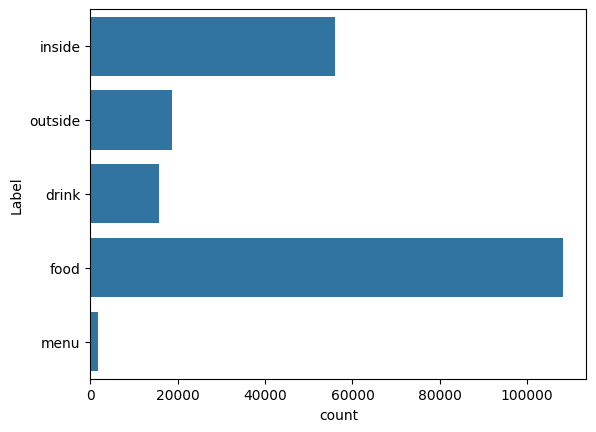

In [ ]:
counts = label_df['Label'].value_counts()
print(counts)
sns.countplot(label_df['Label']);

### Yup probably need to balance that

In [ ]:
min_samples = counts.min()
label_df_smaller = label_df.groupby('Label').apply(lambda x: x.sample(min_samples)).reset_index(drop=True)

In [ ]:
label_df_smaller

,Photo_ID,Label
0,gXsoW6wrXYxJKXsy-ZIKbQ,drink
1,Hn89fHYHmSUmWLQsYCaNIA,drink
2,sBL2TRrEPr1BKnENgue-eA,drink
3,G1OP58atWLOwmWq45lfYKg,drink
4,QjVlxcNn_WsVGMKE_syD2w,drink
...,...,...
8385,HcwaMol7edPpYz2vt_MTgg,outside
8386,nhXCm_Qz-xrvI45DKcXsAA,outside
8387,gTp0WXjpG6rYTsXq0vBqxg,outside
8388,l3Uosm6IFmzYx86KPB1MSA,outside


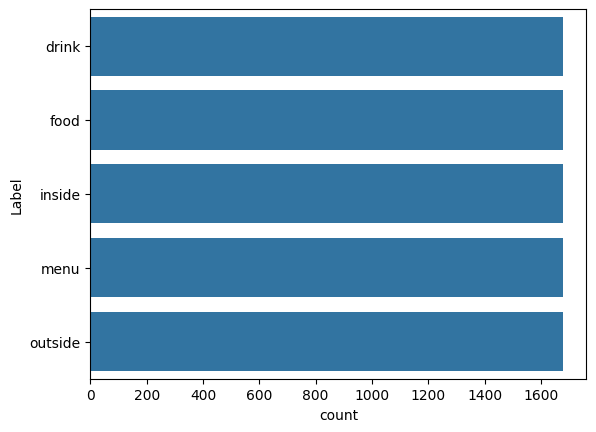

In [ ]:
sns.countplot(label_df_smaller['Label']);

# Load Image Data
### Ok we can just load these 8390 images no need for the entire dataset. Later with data augmentation we can increase the size of the dataset

## Load, resize and convert to arrays

In [ ]:
# let's go with the most popular target size
target_size = (224, 224)
images = []
labels = []

# skip if file has a problem, some files are throwing an error
skipped = []

# yeayyy tqdm
for index, row in tqdm_notebook(label_df_smaller.iterrows(), total=len(label_df_smaller)):
    img_path = os.path.join(data_path, 'photos', f"{row['Photo_ID']}.jpg")
    try:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(row['Label'])
    except:
        skipped.append(img_path)

images = np.array(images)
labels = np.array(labels)

print(f"Total images processed: {images.shape}")
print(f"Total images skipped: {len(skipped)}")

  0%|          | 0/8390 [00:00<?, ?it/s]

Total images processed: (8387, 224, 224, 3)
Total images skipped: 3


In [ ]:
skipped

['./photos\\CA9z96gGA4y9QOes2Y9eGw.jpg',
 './photos\\9X4YPM8nYFjf7hY8xUdc6Q.jpg',
 './photos\\yAf6R6OSgPo8-mmdDh8qIw.jpg']

## Train Test Split

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=42)

In [ ]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((5870, 224, 224, 3), (5870,), (2517, 224, 224, 3), (2517,))

## One-hot Encoding of labels

In [ ]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

train_labels_onehot = onehot_encoder.fit_transform(train_labels.reshape(len(train_labels), 1))
test_labels_onehot = onehot_encoder.transform(test_labels.reshape(len(test_labels), 1))

In [ ]:
onehot_encoder.categories_[0]

array(['drink', 'food', 'inside', 'menu', 'outside'], dtype='<U7')

In [ ]:
train_images.shape, train_labels_onehot.shape, test_images.shape, test_labels_onehot.shape

((5870, 224, 224, 3), (5870, 5), (2517, 224, 224, 3), (2517, 5))

In [ ]:
train_labels[0], train_labels_onehot[0]

('inside', array([0., 0., 1., 0., 0.]))

## Image Preprocessing

In [ ]:
# Normalize train data for DNNs
# DNN don't like rotation and other augumentations
# since they rely on 1D pixel sequences instead of 2D spacial relationship of pixels
datagen_DNNs = ImageDataGenerator(
    rescale=1.0/255.0
)

# Normalize and augment train images
datagen_CNNs = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalize test images. We are not supposed to agument test data but we do need to normalize them.
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create data generators DNNs
train_generator_DNNs = datagen_DNNs.flow(
    train_images, train_labels_onehot, batch_size=32
)

# Create data generators CNNs
train_generator_CNNs = datagen_CNNs.flow(
    train_images, train_labels_onehot, batch_size=32
)

val_generator = val_datagen.flow(
    test_images, test_labels_onehot, batch_size=32
)

In [ ]:
# We need to figure out the number of classes for the output layer
train_labels_onehot.shape[1], test_labels_onehot.shape[1]

(5, 5)

In [ ]:
num_classes = train_labels_onehot.shape[1]

# Modeling

## Baseline CNN model

In [ ]:
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      11,076,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,174,501 (42.63 MB)

 Trainable params: 11,174,501 (42.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_generator_CNNs, epochs=5, validation_data=val_generator)

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 136s 727ms/step - accuracy: 0.3559 - loss: 1.5637 - val_accuracy: 0.4390 - val_loss: 1.3540
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 130s 700ms/step - accuracy: 0.4980 - loss: 1.2173 - val_accuracy: 0.5920 - val_loss: 1.1240
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 127s 686ms/step - accuracy: 0.5709 - loss: 1.0628 - val_accuracy: 0.6508 - val_loss: 0.9600
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 129s 696ms/step - accuracy: 0.5987 - loss: 1.0290 - val_accuracy: 0.6726 - val_loss: 0.9128
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 124s 666ms/step - accuracy: 0.6280 - loss: 0.9731 - val_accuracy: 0.5824 - val_loss: 1.3284


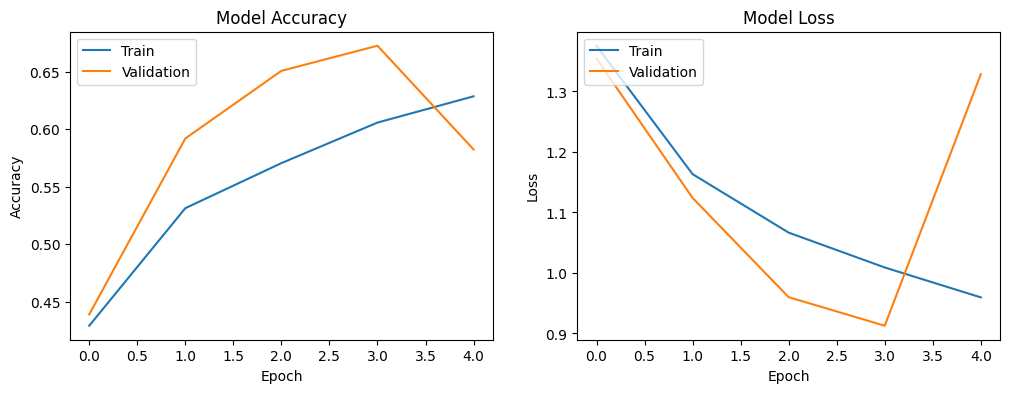

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
model.save('./cnn_model.h5')

## Baseline DNN model

In [ ]:
model = Sequential([
    Flatten(input_shape=(target_size[0], target_size[1], 3)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      77,070,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,235,717 (294.63 MB)

 Trainable params: 77,235,717 (294.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_generator_DNNs, epochs=5, validation_data=val_generator)

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 186ms/step - accuracy: 0.2629 - loss: 26.5846 - val_accuracy: 0.4446 - val_loss: 1.7547
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 187ms/step - accuracy: 0.4141 - loss: 1.8446 - val_accuracy: 0.4327 - val_loss: 1.4524
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 190ms/step - accuracy: 0.5109 - loss: 1.3342 - val_accuracy: 0.4410 - val_loss: 1.5032
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 188ms/step - accuracy: 0.5118 - loss: 1.2597 - val_accuracy: 0.4573 - val_loss: 1.4887
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 189ms/step - accuracy: 0.5322 - loss: 1.2285 - val_accuracy: 0.4386 - val_loss: 1.3760


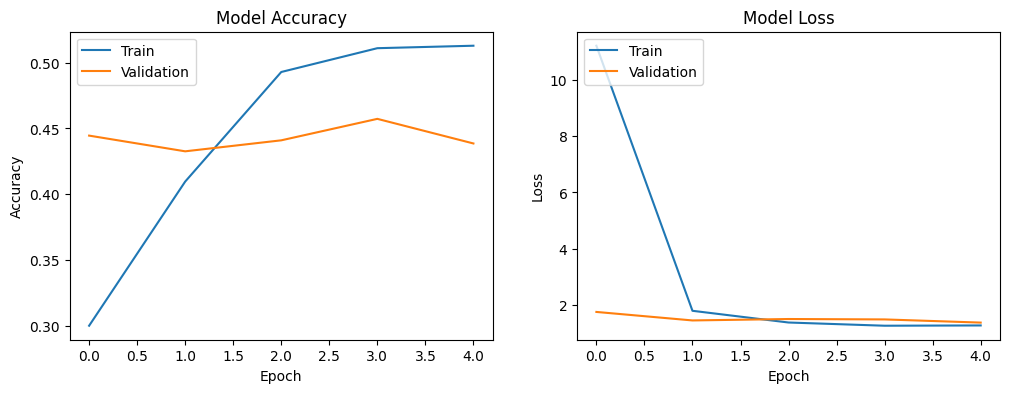

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
model.save('./dnn_model.h5')

### To improve the results the values for different preprocessing steps can be modified, NN architectures can be modified, train for more than 5 epochs, add dropout, etc.

In [ ]:
onehot_encoder.categories_[0]

In [ ]:
import numpy as np
import tensorflow as tf
import gradio as gr
import matplotlib.pyplot as plt
from io import BytesIO

# Load models
cnn_model = tf.keras.models.load_model('cnn_model.h5')
dnn_model = tf.keras.models.load_model('dnn_model.h5')

# Data generator for normalization
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

# Label map
label_map = onehot_encoder.categories_[0]

# Preprocess function
def preprocess(image):
    image = tf.image.resize(image, (224, 224))  # Resize the image
    image = val_datagen.standardize(image)  # Normalize the image using ImageDataGenerator
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Saliency map function
def compute_saliency(model, image):
    image = tf.convert_to_tensor(image)  # Convert image to tensor
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        class_idx = tf.argmax(prediction[0])
        loss = prediction[:, class_idx]
    grads = tape.gradient(loss, image)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]
    return saliency.numpy()  # Convert saliency to numpy array for plotting

# Function to convert matplotlib plot to an image
def fig_to_image(fig):
    buf = BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    img = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    img = plt.imread(buf, format="png")
    buf.close()
    return img

# Plot saliency map function (returns separate images)
def plot_saliency_map(image, saliency):
    # Plot original image
    fig1, ax1 = plt.subplots()
    ax1.imshow(image[0])
    ax1.axis('off')
    ax1.set_title("Original Image")
    original_image = fig_to_image(fig1)
    plt.close(fig1)

    # Plot saliency map
    fig2, ax2 = plt.subplots()
    ax2.imshow(saliency, cmap='hot')
    ax2.axis('off')
    ax2.set_title("Saliency Map")
    saliency_image = fig_to_image(fig2)
    plt.close(fig2)

    return original_image, saliency_image

# Inference and saliency function
def predict_and_explain(image, model_type):
    processed_image = preprocess(image)

    if model_type == "CNN":
        prediction = cnn_model.predict(processed_image)
        saliency = compute_saliency(cnn_model, processed_image)
    else:
        prediction = dnn_model.predict(processed_image)
        saliency = compute_saliency(dnn_model, processed_image)

    label_index = np.argmax(prediction, axis=1)[0]
    label = label_map[label_index]

    original_image, saliency_image = plot_saliency_map(processed_image, saliency)

    return f"Predicted Label: {label}", saliency_image

# Gradio interface
iface = gr.Interface(
    fn=predict_and_explain,
    inputs=[
        gr.Image(type="numpy", label="Upload Image"),
        gr.Radio(choices=["CNN", "DNN"], label="Model Type"),
    ],
    outputs=[
        gr.Textbox(label="Predicted Label"),
        gr.Image(type="numpy", label="Saliency Map")
    ],
    title="Image Classification with CNN and DNN",
    description="Upload an image and select a model type to get the predicted label and see the saliency map."
)

iface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7873
* Running on public URL: https://862942d43d8ca0548f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Created dataset file at: .gradio\flagged\dataset1.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
